# Example of cross-match catalogues with `astroquery`

In [84]:
import os
import numpy as np

import tarfile
import requests

from astropy.table import Table
from astroquery.vizier import Vizier

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

%matplotlib inline
import matplotlib.pylab as plt


## Download XMM-Newton EPIC-pn images

In [78]:
def get_xmm_pps_images(obsid,tmpdir="."):
    """
    Download XMM-Newton EPIC-pn images

    This following function will access the XMM-Newton Science Archive (NXSA) 
    through the AIO interface, and download the EPIC-pn pipeline produced images. 
    It will return one soft band image in [0.5-2] keV and hard-band one in [2-12] keV.
    
    The obsid is the XMM OBS_ID.
    
    The tmpdir can be used as a caching mechanism as the function will check if a tar file
    already exists with the pps_{obsid}.tar name. In this case it will not download again 
    the same pps products for the same OBS_ID.
    
    Author: Ivan Valtchanov, XMM SOC, 2019.
    
    """
    ftype = "IMAGE"
    extn = "FTZ"
    inst = "PN"
    url = 'http://nxsa.esac.esa.int/nxsa-sl/servlet'
    #req  = f"{url}/data-action-aio?obsno={iobs}&name={ftype}&level=PPS"
    req  = f"{url}/data-action-aio?obsno={obsid}&extension={extn}&name={ftype}&instname={inst}&level=PPS"
    tarFile = f"{tmpdir}/pps_{obsid}.tar"

    with requests.get(req) as r:
        #r.raise_for_status() # ensure we notice bad responses
        if (b'No results' in r.content):
            print ("No PPS products found for {obsid}")
            raise Exception
        else:
            with open(tarFile,"wb") as tmp:
                tmp.write(r.content)
    print (f"{inst} images in all bands saved to {tarFile}")
    #
    bands = [2,3,4,5]
    maps = {}
    with tarfile.open(tarFile,'r') as tar:
        for xband in bands:
            sband = f'{xband}000'
            for member in tar.getmembers():
                if (sband in member.name):
                    print (f"Extracting {member.name}")
                    f=tar.extract(member,path=tmpdir)
                    hdu = fits.open(f"{tmpdir}/{member.name}")
                    maps[sband] = hdu[0]
    #
    # co-add the bands to create two images in bands [0.5-2] and [2-12.0] keV. 
    # This means co-adding band 2+3 and 4+5. 
    #
    sb = maps['2000'].data + maps['3000'].data
    hb = maps['4000'].data + maps['5000'].data
    hdu_soft = fits.PrimaryHDU(sb)
    hdu_soft.header = maps['2000'].header
    hdu_hard = fits.PrimaryHDU(hb)
    hdu_hard.header = maps['4000'].header
    #
    return hdu_soft,hdu_hard

## Load the XCLASS published catalogue

The catalogue reference is [Clerc et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012yCat..74233561C/abstract).

In [42]:
# the xclass published catalogue from vizier
Vizier.ROW_LIMIT = -1
tout = Vizier.find_catalogs('J/MNRAS/423/3561')
xcls = Vizier.get_catalogs(xcls.keys())[0]
xclsCat = SkyCoord(ra=xcls['RAJ2000'],dec=xcls['DEJ2000'], unit=(u.deg,u.deg),frame='icrs')
xcls

Xclass,XMMU,RAJ2000,DEJ2000,z,q_z,Counts,MLdet,MLext,extent,offAx,cr1,cr2,Details
,,deg,deg,,,ct,,,arcsec,arcmin,ct / s,ct / s,
int16,bytes16,float32,float32,float32,bytes4,float32,float32,float32,float32,float32,float64,float64,bytes7
20,J125345.1+101142,193.438,10.195,--,,311.7,365.2,103.1,14.2,4.35,0.0344,--,Details
35,J130505.8-101644,196.274,-10.279,0.330,phot,278.3,227.8,115.5,19.4,4.90,0.0311,--,Details
38,J022616.3-023957,36.568,-2.666,--,,642.4,1023.9,481.9,22.9,10.22,0.1368,--,Details
39,J022559.8-024940,36.499,-2.828,0.280,conf,229.8,156.2,89.8,28.2,0.57,0.0143,--,Details
40,J022045.4-032602,35.189,-3.434,0.330,conf,313.3,411.8,166.8,15.9,3.70,0.0367,0.0043,Details
44,J132947.8+114106,202.449,11.685,--,,424.4,309.0,132.3,20.6,7.62,0.0877,0.0134,Details
50,J113115.1-195602,172.813,-19.934,--,,88.3,75.1,46.3,12.6,9.38,0.0135,0.0040,Details
51,J115027.8+014528,177.616,1.758,--,,228.9,266.5,136.0,17.0,3.18,0.0316,0.0135,Details


## Read the BL Lac catalogue from Nuria

In [60]:
filename = os.path.expanduser('~') + '/Desktop/XMMBlazarCatalogue_v2.fits'
tab = Table.read()
#
# take only unique targets
#
objects = [x.decode().strip() for x in tab['Object'].data]
a, idx = np.unique(objects,return_index=True)
utab = tab[idx]
# the catalgue will be with the unique targets
blacCat = SkyCoord(ra=utab['RA'],dec=utab['DEC'],unit=(u.deg,u.deg),frame='icrs')
# display the table with unique sources
utab

Object,RA,DEC,L,B,Redshift,NH,ObsId,ObsDate,Duration,XMM_RA_NOCORR,XMM_DEC_NOCORR,XMM_RADEC_ERR_NOCORR,XMM_RA,XMM_DEC,XMM_RADEC_ERR,PosCorr,AstCorr,PN_ExpID,PN_Mode,PN_SubMode,PN_MinGTI,PN_Det,PN_Reg,PN_Pileup,PN_PileupCorr,PN_Fit,PN_LC,PN_LivT_B_GTI,PN_LivT_A_GTI,PN_SRC_Rate,PN_SRC_ERate,PN_FUL_ET,PN_FUL_E1,PN_FUL_E2,M1_ExpID,M1_Mode,M1_SubMode,M1_MinGTI,M1_Det,M1_Reg,M1_Pileup,M1_PileupCorr,M1_Fit,M1_LC,M1_LivT_B_GTI,M1_LivT_A_GTI,M1_SRC_Rate,M1_SRC_ERate,M1_FUL_ET,M1_FUL_E1,M1_FUL_E2,M2_ExpID,M2_Mode,M2_SubMode,M2_MinGTI,M2_Det,M2_Reg,M2_Pileup,M2_PileupCorr,M2_Fit,M2_LC,M2_LivT_B_GTI,M2_LivT_A_GTI,M2_SRC_Rate,M2_SRC_ERate,M2_FUL_ET,M2_FUL_E1,M2_FUL_E2,PN_SRC_Cts_ET,PN_SRC_ECts_ET,PN_SRC_Cts_E1,PN_SRC_ECts_E1,PN_SRC_Cts_E2,PN_SRC_ECts_E2,PN_KS_Test,PN_Chi2_Test,PN_Fvar_Test,PN_FvarErr_Test,PN_Flare_Test,M1_SRC_Cts_ET,M1_SRC_ECts_ET,M1_SRC_Cts_E1,M1_SRC_ECts_E1,M1_SRC_Cts_E2,M1_SRC_ECts_E2,M1_KS_Test,M1_Chi2_Test,M1_Fvar_Test,M1_FvarErr_Test,M1_Flare_Test,M2_SRC_Cts_ET,M2_SRC_ECts_ET,M2_SRC_Cts_E1,M2_SRC_ECts_E1,M2_SRC_Cts_E2,M2_SRC_ECts_E2,M2_KS_Test,M2_Chi2_Test,M2_Fvar_Test,M2_FvarErr_Test,M2_Flare_Test,Flux_5GHz,Flux_1.4GHz,Flux_5keV,ErrFlux_5keV,Flux_ET,ErrFlux_ET,Flux_E1,ErrFlux_E1,Flux_E2,ErrFlux_E2,Flux_V,ErrFlux_V,Flux_B,ErrFlux_B,Flux_U,ErrFlux_U,Flux_UVW1,ErrFlux_UVW1,Flux_UVW2,ErrFlux_UVW2,Flux_UVM2,ErrFlux_UVM2
,,,,,,,,iso-8601,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes16,float64,float32,float64,float32,float32,float32,int32,bytes10,float64,float32,float64,float32,float32,float64,float32,bool,bool,bytes4,bytes7,bytes17,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float64,float64,float64,bytes4,bytes7,bytes16,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float64,float64,float64,bytes4,bytes7,bytes16,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1207+39W4,182.6108,39.4856,154.9471,74.9882,0.617,0.0199,679780401,2012-12-10,9916.0,182.61,39.4856,2.5924e-05,182.611,39.4858,9.2764e-05,True,True,S001,IMAGING,PrimeSmallWindow,YES,NO,---,---,---,---,---,6.6437,6.6437,0.0,0.0,0.0,0.0,0.0,S002,IMAGING,PrimeFullWindow,YES,YES,YES,NO,---,YES,YES,9.5165,9.5165,0.52,0.01,0.0,0.0,0.0,S003,IMAGING,PrimeFullWindow,YES,YES,YES,NO,---,YES,YES,9.5252,9.5252,0.49,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4949.6,84.9,4027.3,76.0,922.3,37.8,0.0,0.0,0.0,0.0,0.0,4682.7,80.1,3747.9,71.2,934.8,36.8,0.0,0.0,0.0,0.0,0.0,0.3,0.266,0.125,0.005,0.438,0.01,0.235,0.005,0.203,0.007,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.091,0.01
1ES0033+595,8.9692,59.8344,120.9755,-2.9782,0.0,0.424,94381301,2003-02-01,6425.0,8.9684,59.8341,2.1686e-05,8.96841,59.8341,0.000417231,False,True,S003,IMAGING,PrimeSmallWindow,YES,YES,YES,NO,---,YES,YES,4.2091,2.271,4.76,0.06,0.0,0.0,0.0,U002,IMAGING,PrimePartialW2,YES,YES,YES,NO,---,YES,YES,1.6245,0.8299,1.64,0.05,0.0,0.0,0.0,U002,IMAGING,PrimePartialW2,YES,YES,YES,NO,---,YES,YES,1.4806,0.8893,1.72,0.05,0.0,0.0,0.0,9833.9,113.7,6377.3,88.4,3456.5,71.5,0.0,0.0,0.0,0.0,0.0,1364.7,39.4,851.7,31.1,512.9,24.2,0.0,0.0,0.0,0.0,0.0,1481.8,41.2,948.8,33.0,533.0,24.7,0.0,0.0,0.0,0.0,0.0,5.95,1.764,0.712,0.019,1.628,0.025,0.489,0.005,1.137,0.028,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0
1ES0037+405,10.0575,40.8344,120.6459,-21.9876,0.0,0.0627,511380301,2008-01-06,35745.0,10.0577,40.8345,1.68125e-05,10.0574,40.8347,0.000161828,True,True,S003,IMAGING,P

## Cross-match with `SkyCoord` methods

This follows the example in [coordinates matching in astropy](https://docs.astropy.org/en/stable/coordinates/matchsep.html#astropy-coordinates-matching)

In [96]:
#
# search around each BL Lac within 5 arcmin
radius = 5*u.arcmin
idx_xcls, idx_blac, d2d, d3d = blacCat.search_around_sky(xclsCat, radius) 
nx = len(idx_blac)
print (f"*** Found {nx} matches between XCLASS and BL LAC searching within {radius}")
print ('BL Lac name, XLCASS ID, Distance (arcmin)')
for j in range(nx):
    i1 = idx_blac[j]
    i2 = idx_xcls[j]
    print (f"{utab['Object'].data[i1].decode()},{xcls['Xclass'].data[i2]},{d2d[j].to(u.arcmin).value}")
    # save for display
    xobsid = f"{utab['ObsId'].data[i1]:010}"
    cout = SkyCoord(ra=utab['RA'].data[i1],dec=utab['DEC'].data[i1],unit=(u.deg,u.deg))
#

*** Found 2 matches between XCLASS and BL LAC searching within 5.0 arcmin
BL Lac name, XLCASS ID, Distance (arcmin)
XBSJ13304+2415  ,1655,1.371720056357586
CDFSJ03321-2743 ,2313,2.28991250838981


## Nearest neighbours

Alternatively we can search the distance to the nearest XCLASS neighbour of each BL Lac.

In [68]:
# nearest match and its distance
idx, d2d, d3d = blacCat.match_to_catalog_sky(xclsCat)
matches = xclsCat[idx]
nx = len(idx)
print ("BL LAC, XCLASS, Distance (arcmin)")
for j in range(nx):
    print (f"{utab['Object'].data[j].decode()},{xcls['Xclass'].data[idx[j]]},{d2d[j].to(u.arcmin).value}")

BL LAC, XCLASS, Distance (arcmin)
1207+39W4       ,1717,12.079586324008256
1ES0033+595     ,1494,1316.7302977111026
1ES0037+405     ,1494,265.2015416014455
1ES0120+340     ,908,129.0721862940923
1ES0145+138     ,335,587.950417326011
1ES0229+200     ,335,165.36308015422384
1ES0347-121     ,1352,643.4824197401138
1ES0446+449     ,1635,1762.6109355747583
1ES0647+250     ,1603,754.5517312452248
1ES1028+511     ,1069,187.62087268104412
1ES1248-296     ,387,35.81183380743325
1ES1255+244     ,1605,105.79185824177931
1ES1959+650     ,2327,384.11636557215394
1H2351-315      ,2002,93.76306445893172
1WGAJ0057.3-2212,2225,234.18514070473714
1WGAJ03150-5504 ,82,365.3562269707617
1WGAJ0428.8-3805,2303,364.26791958347457
1WGAJ1057.6-7724,510,1283.359531570764
1WGAJ1108.1-7748,510,1268.5139666673945
2E0323+0214     ,1821,52.5077986105048
2E0414+0057     ,408,292.0662210207431
2E1228+1437     ,2260,43.029774416466275
2QZJ002913-2812 ,1030,214.9549744559475
2QZJ113045+0055 ,2045,186.6535015327571
2QZJ21

## Another cluster/group catalogue

Let's try the groups of galaxies in 2MASS survey (Crook+, 2007)

In [73]:
# the xclass published catalogue from vizier
tout = Vizier.find_catalogs('J/ApJ/655/790')
print (Vizier.get_catalogs(tout.keys()))
twomas = Vizier.get_catalogs(tout.keys())[0]
#xclsCat = SkyCoord(ra=xcls['RAJ2000'],dec=xcls['DEJ2000'], unit=(u.deg,u.deg),frame='icrs')
#xcls
two_cat = SkyCoord(ra=twomas['RAJ2000'],dec=twomas['DEJ2000'],unit=(u.hourangle, u.deg))
twomas

TableList with 3 tables:
	'0:J/ApJ/655/790/groups' with 13 column(s) and 2865 row(s) 
	'1:J/ApJ/655/790/large' with 12 column(s) and 44 row(s) 
	'2:J/ApJ/655/790/galaxies' with 9 column(s) and 18737 row(s) 


n_Group,Group,RAJ2000,DEJ2000,Nm,Dist,HV,sigma,Rp,logM,logMp,a,LDC
,,"""h:m:s""","""d:m:s""",,Mpc,km / s,km / s,Mpc,[solMass],[solMass],arcmin,
bytes1,int16,bytes10,bytes9,int16,float32,int32,float32,float32,float32,float32,int16,int16
L,1,00 00 55.2,+28 12 37,3,121.75,9001,190.5,2.95,14.069,14.233,48,--
L,2,00 05 31.5,+27 29 37,3,102.61,7590,86.8,1.95,13.207,13.206,29,--
L,3,00 05 41.8,+05 09 11,3,71.94,5340,41.0,0.64,12.072,11.974,15,--
L,4,00 08 29.8,+32 53 28,7,66.41,4885,108.7,1.34,13.241,13.293,39,--
L,5,00 10 21.2,+28 18 59,3,110.50,8176,134.7,2.38,13.675,13.789,37,--
L,6,00 10 33.0,+47 50 05,20,70.90,5168,146.8,1.80,13.629,13.875,135,--
L,7,00 11 45.6,-57 03 15,4,132.89,9662,167.8,0.88,13.432,13.682,31,--
L,8,00 12 14.6,+22 07 46,4,82.43,6108,178.7,1.00,13.545,13.875,54,--


In [87]:
# search around each BL Lac within 5 arcmin
radius = 15*u.arcmin
idx_twomas, idx_blac, d2d, d3d = blacCat.search_around_sky(two_cat, radius) 
nx = len(idx_blac)
print (f"*** Found {nx} matches between 2MASS and BL LAC searching within {radius}")
print ('BL Lac name, 2MASS GID, Distance (arcmin)')
for j in range(nx):
    i1 = idx_blac[j]
    i2 = idx_twomas[j]
    print (f"{utab['Object'].data[i1].decode()},{twomas['Group'].data[i2]},{d2d[j].to(u.arcmin).value}")
    # save the OBS_ID and the coordinates for visualisation
    xobsid = f"{utab['ObsId'].data[i1]:010}"
    cout = SkyCoord(ra=utab['RA'].data[i1],dec=utab['DEC'].data[i1],unit=(u.deg,u.deg))    

*** Found 1 matches between 2MASS and BL LAC searching within 15.0 arcmin
BL Lac name, 2MASS GID, Distance (arcmin)
MS12292+6430    ,722,7.957705640871344


## Visualise some results


In [97]:
tmpdir = os.path.expanduser('~') + '/Tmp/XMM_data'
xsoft,xhard = get_xmm_pps_images(xobsid,tmpdir=tmpdir)

PN images in all bands saved to /Users/ivaltcha/Tmp/XMM_data/pps_0604961801.tar
Extracting 0604961801/pps/P0604961801PNS003IMAGE_2000.FTZ
Extracting 0604961801/pps/P0604961801PNS003IMAGE_3000.FTZ
Extracting 0604961801/pps/P0604961801PNS003IMAGE_4000.FTZ
Extracting 0604961801/pps/P0604961801PNS003IMAGE_5000.FTZ


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


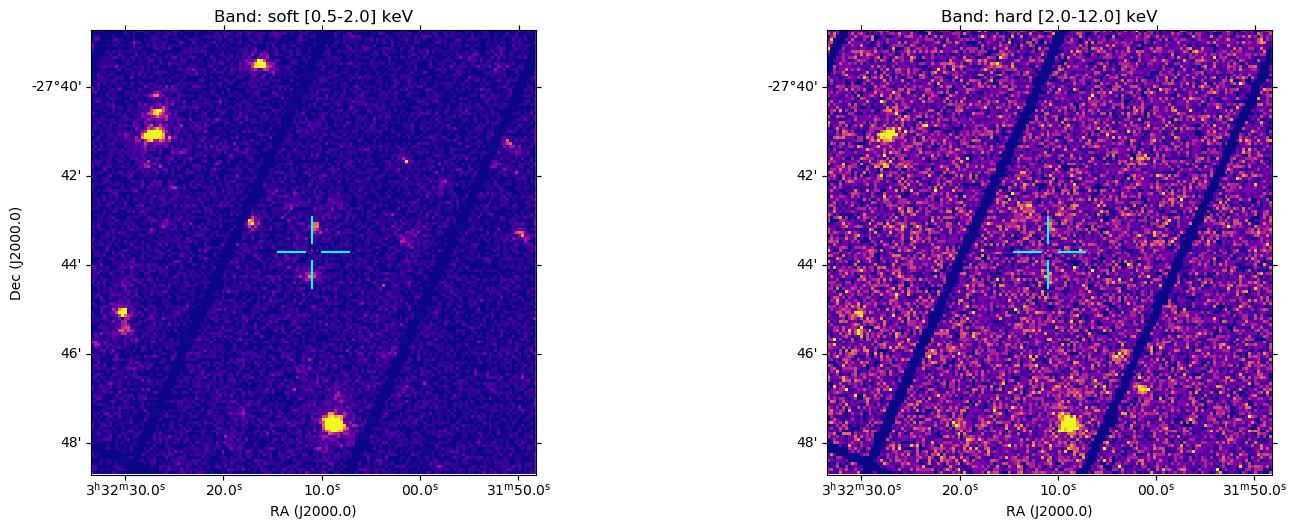

In [98]:
box = 10
saveToFits = False
#
# plotting
#
zoomSize = u.Quantity((box,box), u.arcmin)
#
fig = plt.figure(figsize=(15,5),dpi=100)
#
pp = 99.5 #
# labels for the plots
bands = ["soft [0.5-2.0]","hard [2.0-12.0]"]
qbands = ["500_2000","2000_12000"]
#
saveToFits = False
for i,ximage in enumerate([xsoft,xhard]):
    wcs = WCS(ximage.header)
    cutout = Cutout2D(ximage.data, cout, zoomSize, wcs=wcs,copy=True)
    wcs_cut = cutout.wcs
    ax = fig.add_subplot(1,2,i+1,projection=wcs_cut)
    ax.set_title(f'Band: {bands[i]} keV')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    lat.set_major_formatter('dd:mm')
    if (i == 0):
        lat.set_axislabel('Dec (J2000.0)')
    # now normalize the imahe
    norm = ImageNormalize(cutout.data[~np.isnan(cutout.data)], interval=PercentileInterval(pp))
    ax.imshow(cutout.data,norm=norm,cmap=plt.cm.plasma,origin='lower',interpolation='nearest')
    (xc,yc) = wcs_cut.world_to_pixel(cout)
    #ax.plot(xc,yc,'+m')
    # plot reticle
    inner, outer = 0.02, 0.08
    ax.axvline(xc,ymin=0.5+inner,ymax=0.5+outer,color='cyan')
    ax.axvline(xc,ymin=0.5-inner,ymax=0.5-outer,color='cyan')
    ax.axhline(yc,xmin=0.5+inner,xmax=0.5+outer,color='cyan')
    ax.axhline(yc,xmin=0.5-inner,xmax=0.5-outer,color='cyan')
    ax.set_autoscale_on(False)
    if (saveToFits):
        xdu = fits.PrimaryHDU(cutout.data)
        xdu.header = ximage.header
        xdu.header.update(cutout.wcs.to_header())
        xdu.writeto(f"{output_dir}/{obsid}_{qbands[i]}_norm.fits",overwrite=True)
    #    
ax.set_autoscale_on(False)
#
plt.tight_layout(pad=2)
#lgnd = plt.legend(bbox_to_anchor=(0.2, -0.05))
#lgnd.legendHandles[0]._sizes = [50];